Get the dataset from Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import numpy as np
from PIL import Image
from os import listdir
from xml.etree import ElementTree
import cv2
from google.colab.patches import cv2_imshow


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Tue Jul 26 11:39:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W /  70W |    284MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

Load dataset and split between hands and no hands:

In [ ]:
import os
import numpy as np
from PIL import Image
from os import listdir
from xml.etree import ElementTree
import cv2
from google.colab.patches import cv2_imshow

#import all images
dataset_dir = '/content/drive/My Drive/Colab Notebooks'
images_dir = dataset_dir + '/images/'
boxes_dir = dataset_dir + '/boxes/'

os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset')
os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset/hand')
os.mkdir('/content/drive/My Drive/Colab Notebooks/dataset/no_hand')

i = 0
for filename in listdir(images_dir):
  i = i + 1
  # extract image id
  if(i>=4169):
    image_id = filename[:-4]
    image = cv2.imread(images_dir + filename)
    tree = ElementTree.parse(boxes_dir + image_id + '.xml')
    # get the root of the document
    root = tree.getroot()
    n = 0
    matrix = np.zeros((image.shape[0], image.shape[1])) 
    for box in root.findall('.//bndbox'):
      n = n + 1
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)
      matrix[ymin: ymax, xmin: xmax] = 1
      positive = image[ymin:ymax, xmin:xmax]
      #print(str(image.shape[0]) + ', ' + str(image.shape[1]))
      #print(str(xmin) + ', ' + str(xmax) + ', ' + str(ymin) + ', ' + str(ymax)  + '\n')
      positive = cv2.resize(positive, (448,448), cv2.INTER_CUBIC)
      cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/hand/' 
                  + str(image_id) + '_' + str(n) + '.jpg', positive)
    j=0
    for row in range(0,image.shape[0],224):
        for col in range(0,image.shape[1],224):                   
          if(matrix[row:row+224, col:col+224].sum() == 0):
            negative = image[row : row + 224, col : col + 224]
            negative = cv2.resize(negative,(448,448), cv2.INTER_CUBIC)
            #cv2_imshow(negative)
            cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/no_hand/' 
                        + str(image_id) + '_' + str(j) + '.jpg', negative)
            j=j+1
  print('processed images: ' + str(i))

FileExistsError: ignored

Split into train-validation-test:

In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/dataset'
dataset_dir = '/content/drive/My Drive/Colab Notebooks'
images_dir = dataset_dir + '/images/'
boxes_dir = dataset_dir + '/boxes/'

os.mkdir(data_dir + '/train/')
os.mkdir(data_dir + '/validation/')
os.mkdir(data_dir + '/test/')
os.mkdir(data_dir + '/train/hand')
os.mkdir(data_dir + '/train/no_hand')
os.mkdir(data_dir + '/validation/hand')
os.mkdir(data_dir + '/validation/no_hand')
os.mkdir(data_dir + '/test/hand')
os.mkdir(data_dir + '/test/no_hand')

#process hand samples
i = -1
is_test = True
for filename in listdir('/content/drive/My Drive/Colab Notebooks/dataset/hand'):
  i = i + 1
  # extract image id
  image_id = filename[:-4]
  image = cv2.imread('/content/drive/My Drive/Colab Notebooks/dataset/hand/' + filename)
  #2 images every 8 go one in validation and one in test, the rest is for training
  if i%4 == 0:
    if is_test:
      cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/test/hand/' 
                + str(image_id) + '.jpg', image)
      is_test = False
    else:
      cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/validation/hand/' 
                + str(image_id) + '.jpg', image)
      is_test = True
  else:
      cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/train/hand/' 
                + str(image_id) + '.jpg', image)
  print('processed hand images: ' + str(i))

#process no_hand samples
i = -1
is_test = True
for filename in listdir('/content/drive/My Drive/Colab Notebooks/dataset/no_hand'):
  i = i + 1
  # extract image id
  if(i>53400):
    image_id = filename[:-4]
    image = cv2.imread('/content/drive/My Drive/Colab Notebooks/dataset/no_hand/' + filename)
    if i%4 == 0:
      if is_test:
        cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/test/no_hand/' 
                  + str(image_id) + '.jpg', image)
        is_test = False
      else:
        cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/validation/no_hand/' 
                  + str(image_id) + '.jpg', image)
        is_test = True
    else:
        cv2.imwrite('/content/drive/My Drive/Colab Notebooks/dataset/train/no_hand/' 
                  + str(image_id) + '.jpg', image)
  print('processed no_hand images: ' + str(i))



#final structure of the dataset:
#/dataset/
#        /train/
#              /hand/
#              /no hand/
#        /validation/
#              /hand/
#              /no hand/
#        /test/
#              /hand/
#              /no hand/

Input preprocessing:

Found 43819 images belonging to 2 classes.
Found 8651 images belonging to 2 classes.
Found 8648 images belonging to 2 classes.
train samples: 1370

validation samples: 271

test samples: 8648



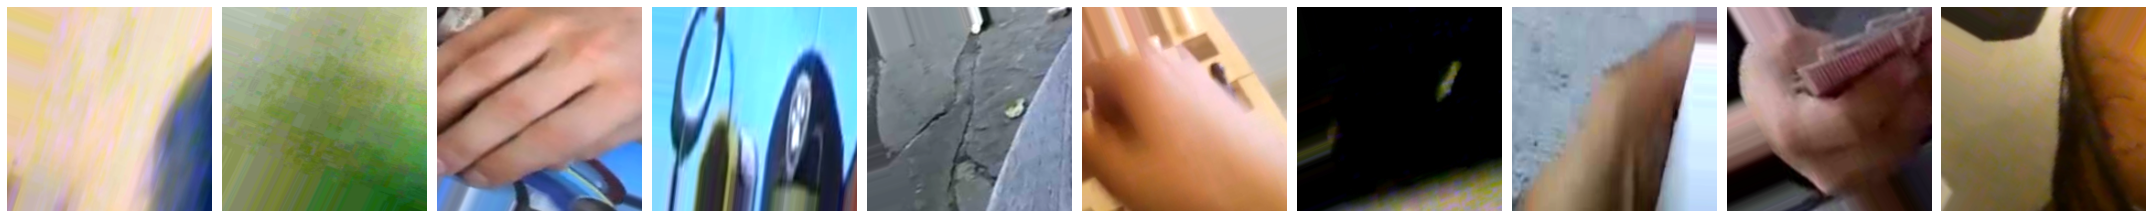

(32, 224, 224, 3)
[1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 1.]


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
import itertools
import random
import warnings
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix

warnings.simplefilter(action='ignore', category=FutureWarning)

train_path = '/content/drive/My Drive/Colab Notebooks/dataset/train'
valid_path = '/content/drive/My Drive/Colab Notebooks/dataset/validation'
test_path = '/content/drive/My Drive/Colab Notebooks/dataset/test'

train_batches = ImageDataGenerator(rescale = 1./255, #rescale rgb values into 0-1
                                   rotation_range = 30, #parameters for data augmentation 
                                   height_shift_range = 0.15,
                                   width_shift_range = 0.15,
                                   zoom_range = 0.2, 
                                   shear_range = 0.2,	
                                   brightness_range=[0.8,1.2],
                                   horizontal_flip = True).flow_from_directory(directory=train_path, target_size=(224,224), color_mode = 'rgb', class_mode='binary', batch_size=32,shuffle=True)
valid_batches = ImageDataGenerator(rescale = 1./255,
                                   brightness_range=[0.9,1.1],
                                   horizontal_flip = True).flow_from_directory(directory=valid_path, target_size=(224,224), color_mode = 'rgb', class_mode='binary', batch_size=32,shuffle=True)
test_batches = ImageDataGenerator(rescale = 1./255, 
                                   brightness_range=[0.9,1.1],
                                   horizontal_flip = True).flow_from_directory(directory=test_path, target_size=(224,224), color_mode = 'rgb', class_mode='binary', batch_size=1,shuffle=True)

#print some training samples
imgs, labels = next(train_batches)

print('train samples: ' + str(len(train_batches)) + '\n')
print('validation samples: ' + str(len(valid_batches)) + '\n')
print('test samples: ' + str(len(test_batches)) + '\n')
#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print(imgs.shape)
print(labels)  #0 is hand, 1 is no hand

Model setup and training:

In [ ]:
resnet_model = ResNet50V2(weights = "imagenet",  include_top = False,  input_tensor = Input(shape = (224,224,3)))
for layer in resnet_model.layers:
	layer.trainable = False

add_model = resnet_model.output
add_model = AveragePooling2D(pool_size=(3, 3))(add_model)
add_model = Flatten()(add_model)
add_model = Dense(128, activation="relu")(add_model)
add_model = Dropout(0.2)(add_model)
add_model = Dense(128, activation="relu")(add_model)
add_model = Dropout(0.3)(add_model)
add_model = Dense(1, activation="sigmoid")(add_model)
model = Model(inputs=resnet_model.input, outputs=add_model)



model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='auto')


model.summary()
history2 = model.fit(train_batches,steps_per_epoch = len(train_batches), epochs= 20, callbacks=[reduce_lr, early_stop],validation_data = valid_batches, validation_steps = len(valid_batches))


model.save('model_resnet50.h5')

print(history2.history)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Evaluation:

In [11]:
model = keras.models.load_model(r"/content/drive/My Drive/model_resnet50.h5")

test_batches.reset()
prediction = model.predict(test_batches, steps = len(test_batches), verbose = 1)

predicted = np.rint(prediction)
true = test_batches.classes

count = 0
for i in range(len(predicted)):
  if predicted[i] == true[i]:
    count = count + 1

accuracy = count/len(predicted)
print('Prediction accuracy: ',accuracy)


n_epochs = 13

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), 
        history2.history["loss"], 
        label="train_loss")
plt.plot(np.arange(0, n_epochs), 
        history2.history["val_loss"], 
        label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('loss_evaluation.png')
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), 
        history2.history["accuracy"], 
        label="train_accuracy")
plt.plot(np.arange(0, n_epochs), 
        history2.history["val_accuracy"], 
        label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig('accuracy_evaluation.png')
plt.show()

8648/8648 [==============================] - 3947s 456ms/step
Prediction accuracy:  0.7250231267345051


NameError: ignored

<Figure size 432x288 with 0 Axes>